## Portfolio Risk Management: Assignment 2
<b>Group 01 (Risk Management):</b>

| Perle Chen | Marc Conin | Wenke Hu | Selina Katlapinski | Sven van Almsick |
| --- | --- | --- | --- | --- |
| 8317422 | 8416520 | 8414690 | 8426023 | 8425957 |
| perle.chen@fs-students.de | marc.coin@fs-students.de | wenke.hu.1@fs-students.de | selina.katlapinski@fs-students.de | sven.van.almsick@fs-students.de |


### Moment Formulas:
$$\text{Mean (p.a.)}= ({\sum_{t=1}^{T}\frac{1}{T}*r_t})*252\text{ days}$$

$$\text{SStd (p.a.)}= \sqrt{\frac{1}{T-1}{\sum_{t=1}^{T}(r_t-\mu)^2}}*\sqrt{252\text{ days}}$$

$$\text{MaxDD} = \frac{\text{Trough Value}}{\text{Peak Value}}-1$$

$$\text{CE} = exp(\frac{1}{T}*{\sum_{t=1}^{T}ln(1+r_t))}-1$$

$$\text{Sharpe Ratio}  = \frac{\mu_i-r_f}{\sigma_i}$$

### Optimal Portfolio weights:
$$\text{weights}_{EF} = \text{weights}_{MSR} = \frac{{\sum^{-1}}E[r_i-r_f]}{1_N^T{\sum^{-1}}E[r_i-r_f]} $$

$$\text{weights}_{MinVola} = \text{weights}_{MeanVariance} = \text{weights}_{MinVar} = \frac{\sum^{-1}1_N}{1_N^T\sum^{-1}1_N}$$

$$\text{weights}_{InverseVola} = \frac{\frac{1}{Std[r_i]}}{{\sum_{j=1}^{N}\frac{1}{Std[r_j]}}}$$

$$\text{weights}_{naive} = \frac{1}{N}$$

In [1]:
# Install all requirements and import all packages
!pip install -r requirements.txt --quiet

import pandas as pd
import numpy as np
import pypfopt as pfopt
import datetime as dt
import sys, os, pathlib
from tabulate import tabulate

from our_modules import *

In [2]:
# Get data
fname = "data/Assignments2020_QP&PRM_05-10-2020.xlsm"

df1 = get_data_nice_looking(fname, 'ETF & FF Factor Time Series', sheet_props={'index_col': 0, 'header': 0, 'parse_dates':'index'})

# Convert EUR and Yen to $
df1 = DF_column_currency_conversion(df1, ['iShares STOXX Europe 600 UCITS ETF (DE) (EXSA.DE) €'], df1['USD/EUR (EUR=X) €'])
df1 = DF_column_currency_conversion(df1, ['iShares Core Nikkei 225 ETF (1329.T) ¥'], df1['USD/JPY (JPY=X) ¥'])
df1.rename(columns={'iShares STOXX Europe 600 UCITS ETF (DE) (EXSA.DE) €':'iShares STOXX Europe 600 UCITS ETF (DE) (EXSA.DE) $', 'iShares Core Nikkei 225 ETF (1329.T) ¥':'iShares Core Nikkei 225 ETF (1329.T) $'}, inplace=True)

df1 = DF_column_bond_conversion(df1, '13 Week Treasury Bill (^IRX) $', output=False)

r_f = df1['13 Week Treasury Bill (^IRX) $'].pct_change().mean() * 252
print('Our risk-free rate for this assignment is:',  r_f)

Our risk-free rate for this assignment is: 0.012216030478387284


### Exercise 1
#### 1a)
<b>Investor's Portfolio:</b>
- 60% Equity
    - 70% US Equity (42%) -> Russell 2000 (small- and mid-cap S&P 500 stocks)
    - 10% EU Equity (6%) -> STOXX Europe 600
    - 10% Emerging Markets (6%)
    - 10% Japan (6%)
- 40% US Bonds
    - 25% long-term US Treasury bonds with a maturity of 20+ years, (10%)
    - 25% US aggregate bonds that also include municipalities, mortgage-backed securities, etc. (10%)
    - 25% high-yield (10%), and
    - 25% investment grade corporate bonds (10%)

<b>Benchmark Portfolio:</b> 
- 60% Wilshire 5000 Total Market Index (W5000) 
- 40% Three-month US Treasury Bills

Calculate from July 18th 2013 until September 16th 2019 quaterly and for the entire period, assuming monthly portfolio rebalancing for both, the baseline portfolio and the benchmark portfolio:
- annualized returns, 
- sharpe ratio, 
- volatility, and
- rolling maximum drawdown.

What do you observe? How do the portfolio weights evolve when applying the Markowitz portfolio theory? How did the portfolio perform during the recent Corona crisis from February 20th 2020 until March 23rd 2020, compared to the benchmark?



### Consideration of the T-Bill ###
Since we are given an annual yield and the bills are discount papers we interpreted this yield as the Coupon Equivalent Rate.
Then - for money market zero bonds - the following formula can be applied:
(I) $$CER = (FV-MP)/MP*(360/d)$$


- CER:    Coupon Equivalent Rate
- FV:     Face Value
- MP:     Market Price
- d:      days until maturity of the security

Solving the equation for the MP leads to the following equation:
(II) $$MP = FV/(1+CER*d/360)$$

Using formula (II) we inserted the following parameters to calculate the daily market price of the T-Bill:

- FV  (face value)
    - This is usually 100 for normal zero bonds, so we assume that value.

- d   days until maturity of the security 
    - Assuming an ‘act/360’ yield convention for the T-Bills we would buy the T-Bill at the rebalancing date into our portfolio. The rebalancing date is assumed to be the first working day each month.
    - At the beginning of the month we assume that the T-Bill has 91 days (13 weeks) until maturity. Then we assume to hold the T-Bill until the rebalancing date in our portfolio. So d would decrease from 91 until about 61 assuming monthly portfolio rebalancing. At the rebalancing date we would sell the T-Bill in our portfolio with d = 61 and buy a new bill under market conditions with d = 91. This way we consider a pulled-to-par effect of the security between the rebalancing dates since the T-Bill is issued at a discount and d would decrease steadily over time increasing the value of the T-Bill.
    - For simplification reasons we assume that if we buy or sell a T-Bill intramonth we would buy a T-Bill that was issued at the beginning of the month.

- CER Coupon Equivalent Rate
    - For the CER we take the annual yield that is given for each trading date in the Excel sheet. Here we assume that this yield is the surrogate for the risk-free rate and that the yield curve is flat so that we don’t have to interpolate yield rates between 61 and 91 days. The CER accounts for the inverse relationship between an increase of market yields and the value of an already bought fixed income security.

#### Consideration of Foreign Currency Denoted ETFs ####
Within the ETFs, two are denoted in foregin currencies. The  iShares STOXX Europe 600 UCITS ETF (DE) (EXSA.DE) is EUR nominated and iShares Core Nikkei 225 ETF (1329.T) in Japanese Yen. For the portfolio calculations, prices are adjusted daily with the respective FX-rates. This allows for simplification of the calculations in regards to correlations between returns and FX rates.


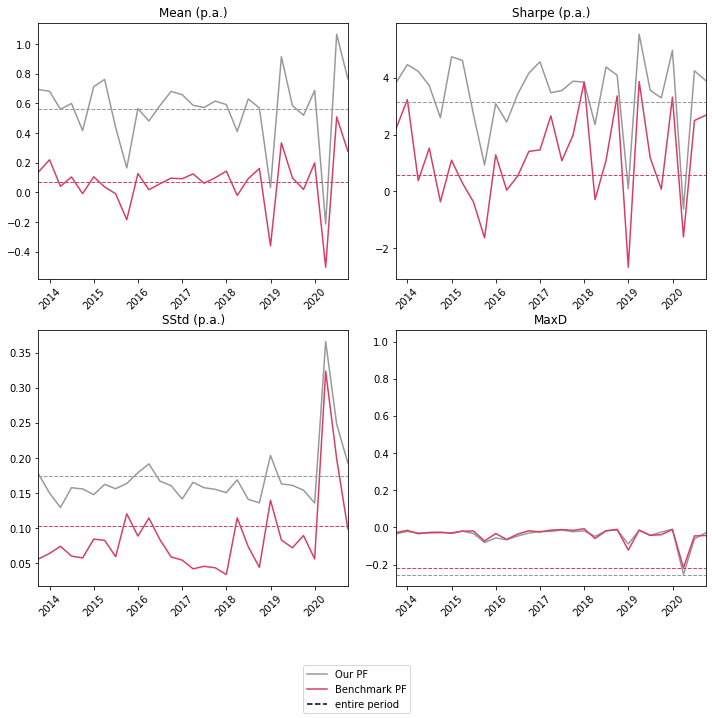

------------------------------
Data Tables:
------------------------------

Mean (p.a.):
                 Our PF    Benchmark PF
-------------  --------  --------------
entire period    0.5625          0.0705
2013-09-30       0.6935          0.1379
2013-12-31       0.6817          0.2197
2014-03-31       0.5601          0.0406
2014-06-30       0.5998          0.1042
2014-09-30       0.4169         -0.0087
2014-12-31       0.7129          0.1053
2015-03-31       0.7616          0.0369
2015-06-30       0.4374         -0.0096
2015-09-30       0.1651         -0.1841
2015-12-31       0.5650          0.1267
2016-03-31       0.4811          0.0179
2016-06-30       0.5848          0.0580
2016-09-30       0.6807          0.0958
2016-12-31       0.6588          0.0921
2017-03-31       0.5871          0.1246
2017-06-30       0.5722          0.0619
2017-09-30       0.6155          0.0988
2017-12-31       0.5920          0.1434
2018-03-31       0.4100         -0.0206
2018-06-30       0.6304        

In [3]:
# Remove data before 2013-07-01
df_returns = df1.pct_change().loc['2013-07-01':'2020-09-17']

# Dictionary with weights from task
our_weight_dict = {'iShares Russell 2000 ETF (IWM) $': 0.42, 'iShares STOXX Europe 600 UCITS ETF (DE) (EXSA.DE) $': 0.1, 'iShares MSCI Emerging Markets ETF (EEM) $': 0.06, 'iShares Core Nikkei 225 ETF (1329.T) $': 0.06, 'iShares 20+ Year Treasury Bond ETF (TLT) $': 0.1, 'iShares Core U.S. Aggregate Bond ETF (AGG) $': 0.1, 'SPDR Bloomberg Barclays High Yield Bond ETF (JNK) $': 0.1, 'iShares iBoxx $ Investment Grade Corporate Bond ETF (LQD) $':0.1}
benchmark_weight_dict = {'Wilshire 5000 Total Market Index (^W5000) $': 0.6, '13 Week Treasury Bill (^IRX) $': 0.4}

# Get PF returns for entire time period
our_PF = PF_value_with_rebalancing(df_returns, our_weight_dict, initial_investment=1, rebalancing='m', percentage=True)['PF Total'].rename('Our PF')
benchmark_PF = PF_value_with_rebalancing(df_returns, benchmark_weight_dict, initial_investment=1, rebalancing='m', percentage=True)['PF Total'].rename('Benchmark PF')

# Check for NaN
#print('NaN:', df_returns[df_returns.isna().any(axis=1)])

# store PF for exercise 4
store_exercise_1 = pd.DataFrame()
store_exercise_1['Our PF'] = our_PF
store_exercise_1['Benchmark PF'] = benchmark_PF

# Calculate Moments for entire time period
PF_moments = {}
PF_moments['entire period'] = moments(pd.concat([our_PF, benchmark_PF], axis=1, sort=False), output=['Mean (p.a.)', 'Sharpe (p.a.)', 'SStd (p.a.)', 'MaxD'], r_f=r_f)

# Get PF returns for each quater
for q, data in df_date_period_iterator(df_returns, period='q', true_date=True):
    our_PF = PF_value_with_rebalancing(data, our_weight_dict, initial_investment=1, rebalancing='m',
                                       percentage=True)['PF Total'].rename('Our PF')
    benchmark_PF = PF_value_with_rebalancing(data, benchmark_weight_dict, initial_investment=1, rebalancing='m',
                                             percentage=True)['PF Total'].rename('Benchmark PF')
    # Calculate quaterly moments
    PF_moments[q] = moments(pd.concat([our_PF, benchmark_PF], axis=1, sort=False), output=['Mean (p.a.)', 'Sharpe (p.a.)', 'SStd (p.a.)', 'MaxD'], r_f=r_f)


# Remove unneccesary Moments that are not asked for in task
PF_moments = transpose_dict_DF(PF_moments, [('head', 'index'),('dict_key','index')])

# Show results
custom_plot(PF_moments, mean_row_loc='entire period')

exp_dict = PF_moments
exp_dict['DATA'] = df_returns
excel_exporter(exp_dict, 'results/assignment_2-exercise_1a.xlsx')


<b>Answer:</b> 
On average, our portfolio performed significantly better than the benchmark portfolio over the entire period. The mean return was higher than the benchmark portfolio throughout the period. However, both portfolios recorded significant drawdowns of returns, especially during the corona crisis. The pattern of changes in returns was similar.

 

The same can be said for the Sharpe ratio. The Sharpe Ratio of our portfolio was also consistently above the Sharpe Ratio of the benchmark portfolio throughout the entire period. It can be seen that over time, the Sharpe ratio of the benchmark portfolio often fell slightly more than that of our portfolio. During the corona crisis, however, it is noticeable that the SR of both portfolios fell roughly equally.

 

With regard to volatility, we were able to observe that our portfolio's volatility was significantly higher than that of the benchmark portfolio over the entire period. What is striking, however, is that during the corona crisis, not only did the volatility of our portfolio rise sharply, but that the volatility of the benchmark portfolio increased to such an extent that it was even at the same high level as our portfolio.

 

With regard to the maximum drawdown, it should be noted that this was roughly the same for both portfolios throughout the entire period. Especially during the corona crisis, both portfolios recorded almost identical drawdowns.


<u>"How do the portfolio weights evolve?"</u> Is answered in 1b)

#### 1b)
Compare the portfolios from 1a) with:
- the Maximum Sharpe-Ratio (MSR) portfolio
- the Minimum Volatility (MinV) portfolio
- the simple 1/N portfolio 

which are calculated by using all N=8 ETFs. 

Calculate from July 18th 2013 until September 16th 2019 quaterly and for the entire period assuming monthly portfolio rebalancing:
- annualized returns,
- sharpe ratio,
- volatility, and
- rolling maximum drawdown.

Do the more complicated portfolio allocation methods produce superior performance results compared to the baseline portfolio and the benchmark portfolio? Elaborate in which way the alternative portfolios perform differently than the baseline portfolio.

**Comment:** The first date where there is data for all eight components is the 02.01.2008. So we use as much data available at the respective time beginning 2008.

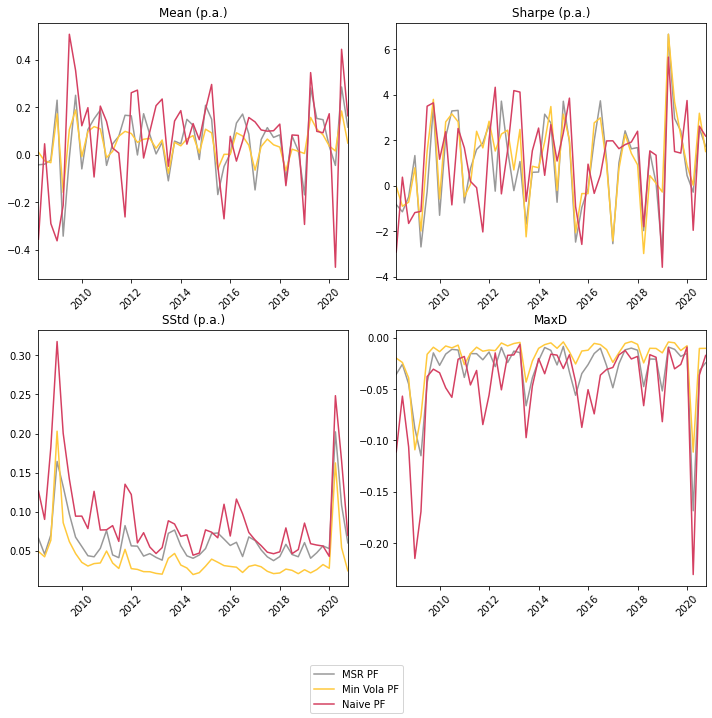

------------------------------
Data Tables:
------------------------------

Mean (p.a.):
* Table output was shrtened to 50 rows.

              MSR PF    Min Vola PF    Naive PF
----------  --------  -------------  ----------
2008-03-31   -0.0425         0.0107     -0.3562
2008-06-30   -0.0401        -0.0260      0.0460
2008-09-30   -0.0224        -0.0336     -0.2905
2008-12-31    0.2299         0.1724     -0.3631
2009-03-31   -0.3434        -0.1590     -0.2133
2009-06-30   -0.0126         0.1056      0.5078
2009-09-30    0.2505         0.1886      0.3556
2009-12-31   -0.0599        -0.0083      0.1220
2010-03-31    0.1062         0.0978      0.1983
2010-06-30    0.1513         0.1184     -0.0940
2010-09-30    0.1881         0.1089      0.2049
2010-12-31   -0.0451        -0.0121      0.1402
2011-03-31    0.0458         0.0143      0.0279
2011-06-30    0.0778         0.0778      0.0069
2011-09-30    0.1663         0.0985     -0.2624
2011-12-31    0.1638         0.0894      0.2611
2012-0

In [4]:
# Earliest Date to use is 02.01.2008 so eraliest return to use is 03.01.2008
available_assets = our_weight_dict.keys()
df_returns = df1[available_assets].pct_change().loc['2008-01-03':]

# Check for NaN
#print('NaN:', df_returns[df_returns.isna().any(axis=1)])

weights = {}

tmp_returns = df_returns.loc['2008-01-01':'2013-07-18']
tmp_MSR_weights = PF_weights(tmp_returns, output='MSR')
tmp_MVola_weights = PF_weights(tmp_returns, output='MVol')
tmp_naive_weights = PF_weights(tmp_returns, output='1/N')

performace = pd.DataFrame(columns=['MSR PF', 'Min Vola PF', 'Naive PF'])

PF_moments = {}

for date, new_df in df_date_period_iterator(df_returns, period='q', true_date=True):
    tmp_moments_MSR = PF_value_with_rebalancing(new_df, tmp_MSR_weights, rebalancing='monthly', percentage=True)['PF Total'].rename('MSR PF')
    tmp_moments_MVola = PF_value_with_rebalancing(new_df, tmp_MVola_weights, rebalancing='monthly', percentage=True)['PF Total'].rename('Min Vola PF')
    tmp_moments_naive = PF_value_with_rebalancing(new_df, tmp_naive_weights, rebalancing='monthly', percentage=True)['PF Total'].rename('Naive PF')
    performace = performace.append(pd.concat([tmp_moments_MSR, tmp_moments_MVola, tmp_moments_naive], axis=1))
    
    PF_moments[date] = moments(pd.concat([tmp_moments_MSR, tmp_moments_MVola, tmp_moments_naive], axis=1, sort=False), output=['Mean (p.a.)', 'Sharpe (p.a.)', 'SStd (p.a.)', 'MaxD'], r_f=r_f)
    
    merged_weights = pd.concat([pd.Series(tmp_MSR_weights).rename('weights_MSR'), pd.Series(tmp_MVola_weights).rename('weights_MVol'), pd.Series(tmp_naive_weights).rename('weights_1/N')], axis=1)
    weights[date] = merged_weights

    tmp_returns = tmp_returns.append(new_df)
    tmp_MSR_weights = PF_weights(tmp_returns, output='MSR')
    tmp_MVola_weights = PF_weights(tmp_returns, output='MVol')
    tmp_naive_weights = PF_weights(tmp_returns, output='1/N')

PF_moments = transpose_dict_DF(PF_moments, [('head', 'index'),('dict_key','index')])

weights = transpose_dict_DF(weights, [('head', 'dict_key'),('head', 'index')])

# Show results
custom_plot(PF_moments)

#Store for exercise 4
store_exercise_1 = pd.concat([store_exercise_1, performace], axis=1)


exp_dict = PF_moments
exp_dict['DATA'] = df_returns
exp_dict.update(weights)
excel_exporter(exp_dict, 'results/assignment_2-exercise_1b.xlsx')


<b>Answer:</b> If we compare the three more complicated portfolio allocation methods with our baseline portfolio and the benchmark portfolio, we can see that all three perform worse on average than our baseline portfolio in terms of annual mean return. Nevertheless, at least the benchmark portfolio is outperformed by the naive portfolio and the MSR portfolio. The minimum volatility portfolio, on the other hand, shows a mean return that is almost similar to that of the benchmark portfolio.

With regard to the sharpe ratio, it is noticeable that the fluctuations in the SR of our baseline portfolio and the benchmark portfolio are significantly greater than those of the more sophisticated portfolio allocation approaches. Only the SR of the minimum volatility portfolio shows stronger outliers.

 

Regarding the volatility of the portfolios, it is noticeable that the minimum volatility portfolio logically has almost no risk. In contrast, the MSR portfolio and the naive portfolio have slightly lower volatility than our baseline portfolio, but slightly higher than the benchmark portfolio. During the corona crisis, as already noted in the previous tasks, the volatility of the portfolios increases similarly sharply. Only the volatility of the minimum volatility portfolio remains constantly at the same low level.

 

The maximum drawdown of the minimum volatility portfolio is close to zero throughout the entire period. The trend of the MDDs of the other two more sophisticated portfolio allocation approaches, however, can be compared with that of the benchmark portfolio and our baseline portfolio.

Therefore, the more complicated portfolio allocation methods do not necessarily outperform our baseline and benchmark portfolios.

### Exercise 2
#### 2a)
Use our portfolio from task 1a) and replace the Russel 2000 ETF, which accounts for 70% in the 60% equity allocation, with the five US equity factor ETFs on momentum, size, value, quality and minimum volatility. Use equal weights for the factor ETFs and assume monthly portfolio rebalancing. Compare this portfolio to the portfolios from task 1a) in terms of:
- annualized returns, 
- volatility, 
- sharpe ratio, and 
- rolling maximum drawdowns.

**Comment:** First date where all assets are available is the 18.07.2013. Thus the first return is available for the 19.07.2020.

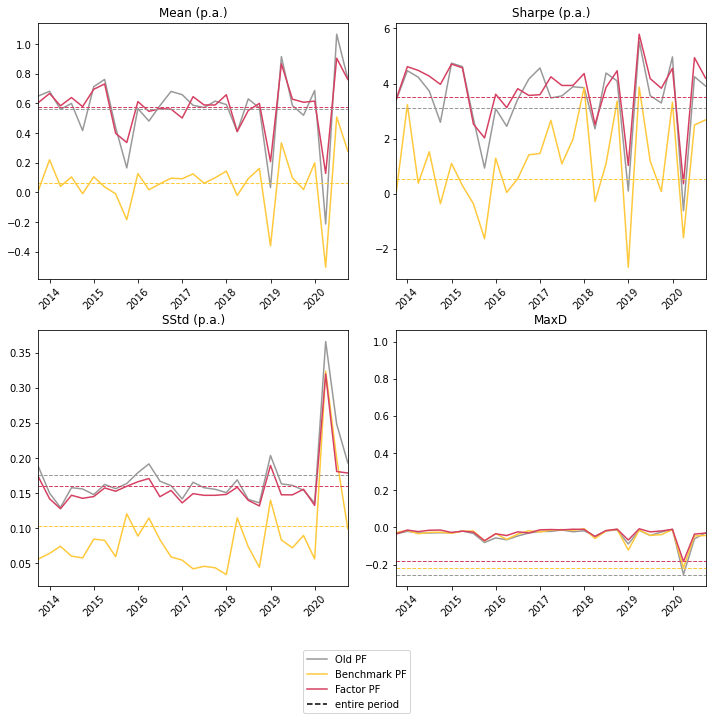

------------------------------
Data Tables:
------------------------------

Mean (p.a.):
                 Old PF    Benchmark PF    Factor PF
-------------  --------  --------------  -----------
entire period    0.5603          0.0666       0.5776
2013-09-30       0.6501          0.0153       0.6062
2013-12-31       0.6817          0.2197       0.6668
2014-03-31       0.5601          0.0406       0.5839
2014-06-30       0.5998          0.1042       0.6394
2014-09-30       0.4169         -0.0087       0.5784
2014-12-31       0.7129          0.1053       0.6950
2015-03-31       0.7616          0.0369       0.7312
2015-06-30       0.4374         -0.0096       0.3983
2015-09-30       0.1651         -0.1841       0.3360
2015-12-31       0.5650          0.1267       0.6122
2016-03-31       0.4811          0.0179       0.5463
2016-06-30       0.5848          0.0580       0.5647
2016-09-30       0.6807          0.0958       0.5611
2016-12-31       0.6588          0.0921       0.5015
2017-03-31

In [5]:
factor_weight_dict = {'iShares Edge MSCI USA Size Factor ETF (SIZE) $': 0.084, 'iShares Edge MSCI USA Value Factor ETF (VLUE) $': 0.084, 'iShares Edge MSCI USA Momentum Factor ETF (MTUM) $': 0.084, 'iShares Edge MSCI USA Quality Factor ETF (QUAL) $': 0.084, 'iShares Edge MSCI Min Vol USA ETF (USMV) $': 0.084,'iShares STOXX Europe 600 UCITS ETF (DE) (EXSA.DE) $': 0.1, 'iShares MSCI Emerging Markets ETF (EEM) $': 0.06, 'iShares Core Nikkei 225 ETF (1329.T) $': 0.06, 'iShares 20+ Year Treasury Bond ETF (TLT) $': 0.2, 'iShares Core U.S. Aggregate Bond ETF (AGG) $': 0.2}

# Earliest Date to use is 18.07.2013 so eraliest return to use is 19.07.2013
df_returns = df1.pct_change().loc['2013-07-19':]

# Check for NaN
#print('NaN:', df_returns[df_returns.isna().any(axis=1)])

# Get PF returns for entire time period
old_PF = PF_value_with_rebalancing(df_returns, our_weight_dict, rebalancing='m', percentage=True)['PF Total'].rename('Old PF')
factor_PF = PF_value_with_rebalancing(df_returns, factor_weight_dict, rebalancing='m', percentage=True)['PF Total'].rename('Factor PF')
benchmark_PF = PF_value_with_rebalancing(df_returns, benchmark_weight_dict, rebalancing='m', percentage=True)['PF Total'].rename('Benchmark PF')

# Calculate Moments for entire time period
PF_moments = {}
PF_moments['entire period'] = moments(pd.concat([old_PF, benchmark_PF, factor_PF], axis=1, sort=False), output=['Mean (p.a.)', 'Sharpe (p.a.)', 'SStd (p.a.)', 'MaxD'], r_f=r_f)

# Get PF returns for each quater
for q, data in df_date_period_iterator(df_returns, period='q', true_date=True):
    our_PF = PF_value_with_rebalancing(data, our_weight_dict, rebalancing='m', percentage=True)['PF Total'].rename('Old PF')
    factor_PF = PF_value_with_rebalancing(data, factor_weight_dict, rebalancing='m', percentage=True)['PF Total'].rename('Factor PF')
    benchmark_PF = PF_value_with_rebalancing(data, benchmark_weight_dict, rebalancing='m', percentage=True)['PF Total'].rename('Benchmark PF')
    # Calculate quaterly moments
    PF_moments[q] = moments(pd.concat([our_PF, benchmark_PF, factor_PF], axis=1, sort=False), output=['Mean (p.a.)', 'Sharpe (p.a.)', 'SStd (p.a.)', 'MaxD'], r_f=r_f)


# Remove unneccesary Moments that are not asked for in task
PF_moments = transpose_dict_DF(PF_moments, [('head', 'index'),('dict_key','index')])


# Show results
custom_plot(PF_moments, mean_row_loc='entire period')

exp_dict = PF_moments
exp_dict['DATA'] = df_returns
excel_exporter(exp_dict, 'results/assignment_2-exercise_2a.xlsx')

<b>Answer:</b> In comparison with the portfolios from task 1a), it can be seen that the factor portfolio also outperforms the benchmark portfolio. The mean return is therefore also significantly higher than the benchmark portfolio. In comparison to the previous portfolio from 1a), however, a similar pattern can be seen throughout the entire period. Especially during the corona crisis, the mean return of both portfolios fell almost equally strongly, whereby it is noticeable that the mean return of the factor portfolio fell slightly less strongly during the drawdown at the end of 2018 and during the corona crisis.

 

Regarding the sharpe ratio, it is noticeable that the old portfolio and the factor portfolio also show a very similar pattern. The SR of both portfolios is therefore also higher than that of the benchmark portfolio.

 

The same can be observed with regard to volatility. Again, the factor portfolio shows a very similar trend to the old portfolio, which is particularly similar during the corona crisis. The volatility of the benchmark portfolio is therefore, as already determined in task 1a), again significantly lower than that of the old and factor portfolios. Only during the corona crisis does the volatility of the benchmark portfolio increase very sharply, reaching the same level as the other two portfolios.

 

The pattern of the maximum drawdowns of the three analysed portfolios is very similar throughout the entire period. Only during the drawdown at the end of 2018, the benchmark portfolio recorded slightly lower maximum drawdowns. The MDDs of the other two portfolios are again very similar during the observed period.

#### 2b)
Compare the Portfolios from 2a with:
- the Maximum Sharpe-Ratio (MSR) portfolio
- the Minimum Volatility (MinV) portfolio
- the simple 1/N portfolio 

which are calculated by using all N=12 ETFs from task 2a). 

Calculate from July 18th 2013 until September 16th 2019 quaterly and for the entire period assuming monthly portfolio rebalancing:
- annualized returns,
- sharpe ratio,
- volatility, and
- rolling maximum drawdown.
 
Do the more complicated portfolio allocation methods produce superior performance results compared to the baseline factor portfolio the “naïve” baseline portfolio from exercise 1 and the benchmark portfolio? Elaborate in which way the alternative factor portfolios perform differently than the baseline portfolio. How do the portfolio weights evolve when applying the Markowitz portfolio theory?

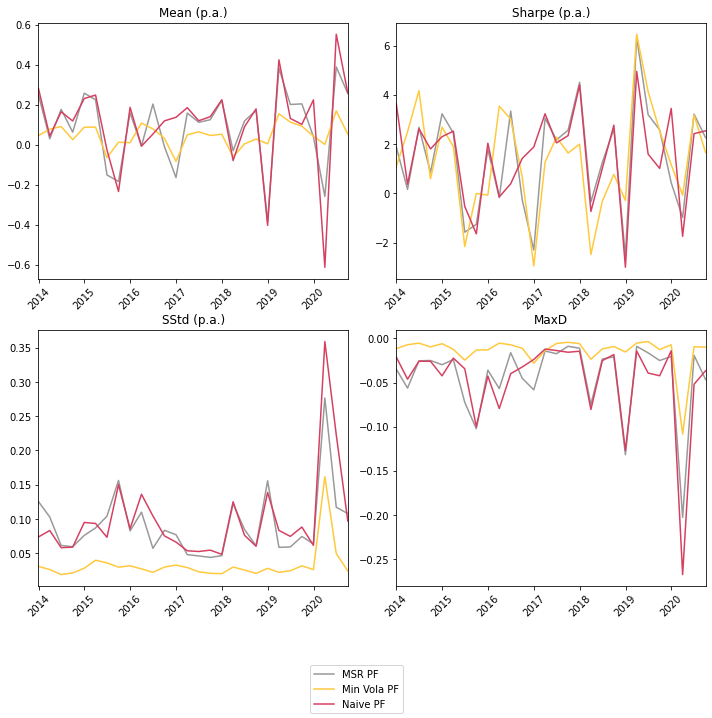

------------------------------
Data Tables:
------------------------------

Mean (p.a.):
              MSR PF    Min Vola PF    Naive PF
----------  --------  -------------  ----------
2013-12-31    0.2497         0.0455      0.2813
2014-03-31    0.0289         0.0774      0.0431
2014-06-30    0.1767         0.0906      0.1645
2014-09-30    0.0624         0.0248      0.1184
2014-12-31    0.2578         0.0874      0.2307
2015-03-31    0.2247         0.0878      0.2482
2015-06-30   -0.1518        -0.0650     -0.0266
2015-09-30   -0.1843         0.0121     -0.2345
2015-12-31    0.1593         0.0099      0.1866
2016-03-31   -0.0067         0.1081     -0.0074
2016-06-30    0.2032         0.0786      0.0529
2016-09-30   -0.0099         0.0317      0.1191
2016-12-31   -0.1648        -0.0840      0.1369
2017-03-31    0.1583         0.0491      0.1851
2017-06-30    0.1120         0.0643      0.1197
2017-09-30    0.1247         0.0460      0.1398
2017-12-31    0.2214         0.0523      0.2246

In [6]:
# Earliest Date to use is 02.01.2008 so eraliest return to use is 03.01.2008
available_assets = factor_weight_dict.keys()
df_returns = df1[available_assets].pct_change().loc['2013-07-19':]

# Check for NaN
#print('NaN:', df_returns[df_returns.isna().any(axis=1)])

tmp_returns = df_returns.loc['2013-07-19':'2013-10-01']
tmp_MSR_weights = PF_weights(tmp_returns, output='MSR')
tmp_MVola_weights = PF_weights(tmp_returns, output='MVol')
tmp_naive_weights = PF_weights(tmp_returns, output='1/N')

weights = {}
PF_moments = {}

for date, new_df in df_date_period_iterator(df_returns.loc['2013-10-01':], period='q', true_date=True):
    tmp_moments_MSR = PF_value_with_rebalancing(new_df, tmp_MSR_weights, rebalancing='monthly', percentage=True)['PF Total'].rename('MSR PF')
    tmp_moments_MVola = PF_value_with_rebalancing(new_df, tmp_MVola_weights, rebalancing='monthly', percentage=True)['PF Total'].rename('Min Vola PF')
    tmp_moments_naive = PF_value_with_rebalancing(new_df, tmp_naive_weights, rebalancing='monthly', percentage=True)['PF Total'].rename('Naive PF')
    
    PF_moments[date] = moments(pd.concat([tmp_moments_MSR, tmp_moments_MVola, tmp_moments_naive], axis=1, sort=False), output=['Mean (p.a.)', 'Sharpe (p.a.)', 'SStd (p.a.)', 'MaxD'], r_f=r_f)

    merged_weights = pd.concat([pd.Series(tmp_MSR_weights).rename('weights_MSR'), pd.Series(tmp_MVola_weights).rename('weights_MVol'), pd.Series(tmp_naive_weights).rename('weights_1/N')], axis=1)
    weights[date] = merged_weights

    tmp_returns = tmp_returns.append(new_df)
    tmp_MSR_weights = PF_weights(tmp_returns, output='MSR')
    tmp_MVola_weights = PF_weights(tmp_returns, output='MVol')
    tmp_naive_weights = PF_weights(tmp_returns, output='1/N')

PF_moments = transpose_dict_DF(PF_moments, [('head', 'index'),('dict_key','index')])
weights = transpose_dict_DF(weights, [('head', 'dict_key'),('head', 'index')])
# Show results
custom_plot(PF_moments)

exp_dict = PF_moments
exp_dict['DATA'] = df_returns
exp_dict.update(weights)
excel_exporter(exp_dict, 'results/assignment_2-exercise_2b.xlsx')

<b>Answer:</b> If we compare the three more complicated portfolio allocation methods with our baseline portfolio and the benchmark portfolio, it can be seen that, as in task 1b), all three methods perform worse on average than our baseline portfolio in terms of their annual mean return. The benchmark portfolio, on the other hand, follows a similar pattern as the naïve portfolio, while the mean return of the benchmark portfolio is still higher on average during the corona crisis.

 

The trend of the sharpe ratio of the three more sophisticated portfolio allocation approaches is similar to the SR of the benchmark portfolio. In contrast, the SR of our baseline portfolio outperformed on average the SR of the more sophisticated portfolio allocation methods.

 

With regard to the volatility of the portfolios, it is striking that the minimum volatility portfolio shows only a low volatility, which only increased slightly during the corona crisis. The MSR portfolio and the naive portfolio, on the other hand, show a very similar volatility curve to the benchmark portfolio. Our baseline portfolio, which has a higher volatility than the benchmark portfolio, also has a higher volatility than the three more complicated portfolio allocation methods.

 

The maximum drawdown of the minimum volatility portfolio is below -0.05 for most of the period, with the exception of the corona crisis, when a stronger drawdown was recorded. The MDDs of the other two more sophisticated portfolio allocation approaches can be compared to the benchmark portfolio and our baseline portfolio. In each case, strong drawdowns of up to -0.25 were recorded.

Therefore, the more complicated portfolio allocation methods could not outperform our baseline portfolio, but came very close to the performance of the benchmark portfolio.

Portfolio weights significantly change when applying the Markowitz portfolio theory. Further, the weights heavily flactuate given the rolling window approach while our baseline portfolio holds the weights steady throughout the whole period, this might be attached to higher rebalancing costs. The weight of iShares Edge MSCI USA Quality Factor ETF in the maximum Sharpe Ratio PF increases to around 30% for the first OOS quarter from an inital weight of 8.4% and peaks at nearly 70% the quarter hereafter.

#### 2c)
Analyze from July 18th 2013 until September 16th 2020 the performance of 
- the US value factor compared to 
- the US momentum factor 

in terms of their 
- annualized returns, 
- volatility, 
- Sharpe ratios, and 
- maximum drawdowns.

Do you also observe the underperformance of the value factor the researchers from AQR observed? 

In [7]:
df_returns = df1[['iShares Edge MSCI USA Value Factor ETF (VLUE) $', 'iShares Edge MSCI USA Momentum Factor ETF (MTUM) $']].pct_change().loc['2013-07-19':]
mom = moments(df_returns, output=['Mean (p.a.)', 'Sharpe (p.a.)', 'SStd (p.a.)', 'MaxD'], r_f=r_f)
print_nice_data_tables(mom)

------------------------------
Data Table:
------------------------------
                                                      Mean (p.a.)    Sharpe (p.a.)    SStd (p.a.)     MaxD
--------------------------------------------------  -------------  ---------------  -------------  -------
iShares Edge MSCI USA Value Factor ETF (VLUE) $            0.0854           0.3805         0.1923  -0.3947
iShares Edge MSCI USA Momentum Factor ETF (MTUM) $         0.1699           0.8394         0.1879  -0.3408



<b>Answer:</b> The comparison of the two ETFs shows that the US Value Factor ETF clearly underperforms in terms of its annual mean return. The mean return of the US Momentum Factor ETF is 16.99%, whereas the mean return of the US Value Factor ETFs is only 8.54%.

Similarly, the Sharpe Ratio of the US Value Factor ETF is only 0.4440 and thus significantly lower than the SR of the US Momentum Factor ETF of 0.9044.

The volatility of the two ETFs, however, does not differ that much. The annual volatility of the US Value Factor ETF is only slightly higher than that of the US Momentum Factor ETF.

Beyond that, the maximum drawdown of the US Value Factor ETF with -0.3947 is also stronger than that of the US Momentum Factor ETF with -0.3408.

 

In conclusion, AQR's observation that the Value Factor ETF underperforms the Momentum Factor ETF is correct.

### Exercise 3
#### 3a)
Use our portfolio from task 1a) and replace the international equity part, the 30% in the 60% equity allocation, with the four liquid alternative ETFs, “Real Estate Investment Trusts” (REIT), Multi-strategy hedge-funds, global infrastructure companies and global private-equity firms (columns X to AA). Use equal weights for the alternative investment ETFs and assume monthly portfolio rebalancing. Compare this portfolio to the portfolios from task 1a) in terms of their:
- annualized returns, 
- volatility, 
- sharpe ratio, and 
- rolling maximum drawdowns.

How does this portfolio perform compared to the baseline portfolio, and its benchmark? Do alternative assets in this baseline comparison offer some insights into their performance properties compared to regular broad market ETFs? 

Also calculate how correlated the liquid alternatives on an annual basis are compared to the Wilshire 5000 Total Market Index (W5000).

**Comment:** First date where all assets are available is the 25.03.2009. Thus the first return is available for the 26.03.2009.

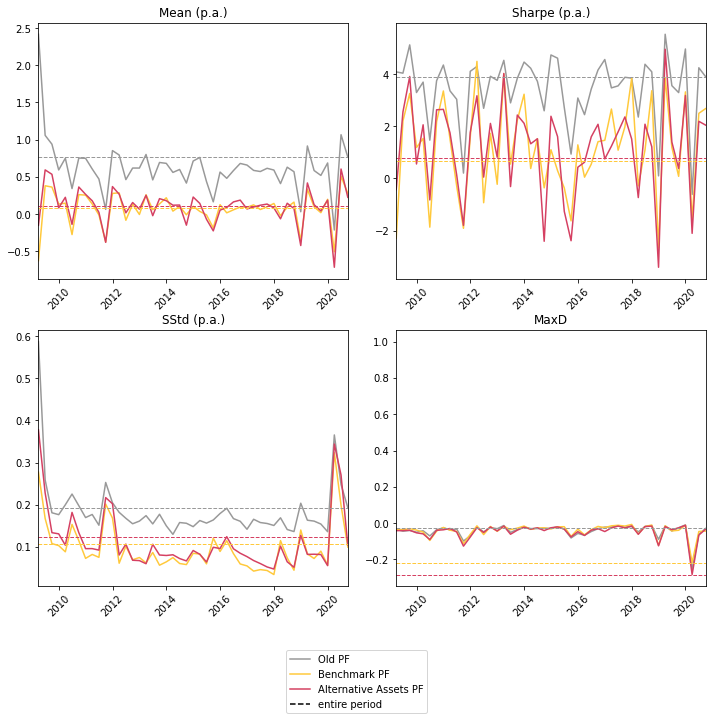

------------------------------
Data Tables:
------------------------------

Mean (p.a.):
                 Old PF    Benchmark PF    Alternative Assets PF
-------------  --------  --------------  -----------------------
entire period    0.7665          0.0858                   0.1093
2009-03-31       2.4149         -0.6240                  -0.1499
2009-06-30       1.0577          0.3810                   0.5939
2009-09-30       0.9391          0.3631                   0.5348
2009-12-31       0.5935          0.1344                   0.0847
2010-03-31       0.7509          0.1473                   0.2261
2010-06-30       0.3433         -0.2742                  -0.1377
2010-09-30       0.7530          0.2620                   0.3643
2010-12-31       0.7498          0.2555                   0.2656
2011-03-31       0.6066          0.1363                   0.1798
2011-06-30       0.4716         -0.0096                   0.0243
2011-09-30       0.0641         -0.3734                  -0.3784
2

In [8]:
alternative_weight_dict = {'iShares Russell 2000 ETF (IWM) $': 0.42, 'iShares Core U.S. REIT ETF (USRT) $': 0.045, 'IQ Hedge Multi-Strategy Tracker ETF (QAI) $': 0.045, 'iShares Global Infrastructure ETF (IGF) $': 0.045, 'Invesco Global Listed Private Equity ETF (PSP) $': 0.045, 'iShares 20+ Year Treasury Bond ETF (TLT) $': 0.1, 'iShares Core U.S. Aggregate Bond ETF (AGG) $': 0.1,"SPDR Bloomberg Barclays High Yield Bond ETF (JNK) $":0.1, "iShares iBoxx $ Investment Grade Corporate Bond ETF (LQD) $":0.1}

# Get asset returns 
df_returns = df1.pct_change().loc['2009-03-26':]
 
# Check for NaN
#print('NaN:', df_returns[df_returns.isna().any(axis=1)])

# Get PF returns for entire time period
old_PF = PF_value_with_rebalancing(df_returns, our_weight_dict, rebalancing='m', percentage=True)['PF Total'].rename('Old PF')
alternative_PF = PF_value_with_rebalancing(df_returns, alternative_weight_dict, rebalancing='m', percentage=True)['PF Total'].rename('Alternative Assets PF')
benchmark_PF = PF_value_with_rebalancing(df_returns, benchmark_weight_dict, rebalancing='m', percentage=True)['PF Total'].rename('Benchmark PF')


# Calculate Moments for entire time period
PF_moments = {}
PF_moments['entire period'] = moments(pd.concat([our_PF, benchmark_PF, alternative_PF], axis=1, sort=False), output=['Mean (p.a.)', 'Sharpe (p.a.)', 'SStd (p.a.)', 'MaxD'], r_f=r_f)

# Get PF returns for each quater
for q, data in df_date_period_iterator(df_returns, period='q', true_date=True):
    our_PF = PF_value_with_rebalancing(data, our_weight_dict, rebalancing='m', percentage=True)['PF Total'].rename('Old PF')
    alternative_PF = PF_value_with_rebalancing(data, alternative_weight_dict, rebalancing='m', percentage=True)['PF Total'].rename('Alternative Assets PF')
    benchmark_PF = PF_value_with_rebalancing(data, benchmark_weight_dict, rebalancing='m', percentage=True)['PF Total'].rename('Benchmark PF')
    # Calculate quaterly moments
    PF_moments[q] = moments(pd.concat([our_PF, benchmark_PF, alternative_PF], axis=1, sort=False), output=['Mean (p.a.)', 'Sharpe (p.a.)', 'SStd (p.a.)', 'MaxD'], r_f=r_f)


# Remove unneccesary Moments that are not asked for in task
PF_moments = transpose_dict_DF(PF_moments, [('head', 'index'),('dict_key','index')])


# Show results
custom_plot(PF_moments, mean_row_loc='entire period')

exp_dict = PF_moments
exp_dict['DATA'] = df_returns
excel_exporter(exp_dict, 'results/assignment_2-exercise_3a.xlsx')

<AxesSubplot:>

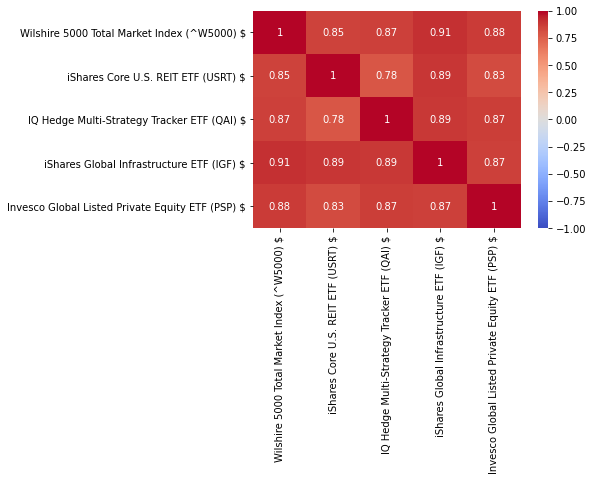

In [9]:
# correlation question part
import seaborn as sns
stocks = ['Wilshire 5000 Total Market Index (^W5000) $', 'iShares Core U.S. REIT ETF (USRT) $', 'IQ Hedge Multi-Strategy Tracker ETF (QAI) $', 'iShares Global Infrastructure ETF (IGF) $', 'Invesco Global Listed Private Equity ETF (PSP) $']
df_returns = df1[stocks].pct_change().loc['2019-03-26':]

# print(df_returns.corr())
sns.heatmap(df_returns.corr(), annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm')

</b> Answer:</b>

The “naïve” portfolio with equally weighted alternative asset ETFs (AA ETFs) replacing the international equity ETFs allocated weights of 4.5% to each of the four AA ETFs. Over the observation period, this portfolio underperformed compared to the actual “naïve” portfolio and the benchmark portfolio in terms of risk-adjusted returns measured by the Sharpe Ratio. 

Only from March through May 2019, the “naïve” PF with AA ETFs delivered a higher Sharpe Ratio. Hereafter, it closely mirrors the performance development of the benchmark portfolio. 

The performance properties seem to share similarities to the broad market Wilshire 5000 Total Market Index. When examining the individual AA ETFs, it become apparent how the performance relates back to the broad market development. 	The strong correlation between housing market, infrastructure investments, private equity activity and total economic development is established in economic literature and reflected in the correlation matrix above. 

The observations indicate that the inclusion of international equity ETFs to our baseline portfolio achieves better performance than AAs ETF for the observed period. This might be due to the steeper growth in the economies related to the international equity ETFs. The AAs ETFs contribute to less volatile returns in the baseline PF. 


#### 3b)
Compare the portfolios from task 3a) with:
- the Maximum Sharpe-Ratio (MSR) portfolio
- the Minimum Volatility (MinV) portfolio
- the simple 1/N portfolio 

which is calculated by using all N=9 ETFs from task 3a). 

Calculate from July 18th 2013 until September 16th 2019 quaterly and for the entire period assuming monthly portfolio rebalancing:
- annualized returns,
- sharpe ratio,
- volatility, and
- rolling maximum drawdown.

Do the more complicated portfolio allocation methods produce superior performance results compared to the baseline liquid alternative portfolio, the “naïve” baseline portfolio from exercise 1 and the benchmark portfolio? Elaborate in which way the liquid alternatives portfolios perform differently than the baseline portfolios and whether liquid alternatives do improve portfolio performance. How do the portfolio weights evolve when applying the Markowitz portfolio theory?

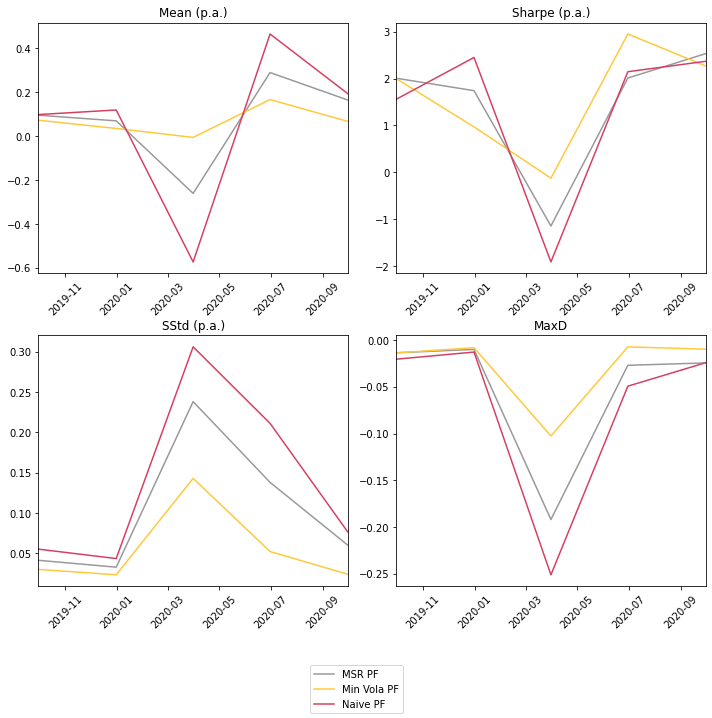

------------------------------
Data Tables:
------------------------------

Mean (p.a.):
              MSR PF    Min Vola PF    Naive PF
----------  --------  -------------  ----------
2019-09-30    0.0954         0.0725      0.0983
2019-12-31    0.0696         0.0350      0.1191
2020-03-31   -0.2607        -0.0058     -0.5732
2020-06-30    0.2897         0.1666      0.4653
2020-09-30    0.1645         0.0671      0.1934


Sharpe (p.a.):
              MSR PF    Min Vola PF    Naive PF
----------  --------  -------------  ----------
2019-09-30    2.0065         1.9979      1.5581
2019-12-31    1.7411         0.9684      2.4495
2020-03-31   -1.1466        -0.1260     -1.9134
2020-06-30    2.0103         2.9501      2.1455
2020-09-30    2.5310         2.2686      2.3669


SStd (p.a.):
              MSR PF    Min Vola PF    Naive PF
----------  --------  -------------  ----------
2019-09-30    0.0415         0.0302      0.0553
2019-12-31    0.0329         0.0235      0.0436
2020-03-31    0

In [10]:
# Earliest Date to use is 25.03.2019 so eraliest return to use is 26.03.2019
available_assets = alternative_weight_dict.keys()
df_returns = df1[available_assets].pct_change().loc['2009-03-26':]

# Check for NaN
#print('NaN:', df_returns[df_returns.isna().any(axis=1)])

tmp_returns = df_returns.loc['2009-03-26':'2019-07-01']
tmp_MSR_weights = PF_weights(tmp_returns, output='MSR')
tmp_MVola_weights = PF_weights(tmp_returns, output='MVol')
tmp_naive_weights = PF_weights(tmp_returns, output='1/N')

weights = {}
PF_moments = {}

for date, new_df in df_date_period_iterator(df_returns.loc['2019-07-01':], period='q', true_date=True):
    tmp_moments_MSR = PF_value_with_rebalancing(new_df, tmp_MSR_weights, rebalancing='monthly', percentage=True)['PF Total'].rename('MSR PF')
    tmp_moments_MVola = PF_value_with_rebalancing(new_df, tmp_MVola_weights, rebalancing='monthly', percentage=True)['PF Total'].rename('Min Vola PF')
    tmp_moments_naive = PF_value_with_rebalancing(new_df, tmp_naive_weights, rebalancing='monthly', percentage=True)['PF Total'].rename('Naive PF')
    
    PF_moments[date] = moments(pd.concat([tmp_moments_MSR, tmp_moments_MVola, tmp_moments_naive], axis=1, sort=False), output=['Mean (p.a.)', 'Sharpe (p.a.)', 'SStd (p.a.)', 'MaxD'], r_f=r_f)

    merged_weights = pd.concat([pd.Series(tmp_MSR_weights).rename('weights_MSR'), pd.Series(tmp_MVola_weights).rename('weights_MVol'), pd.Series(tmp_naive_weights).rename('weights_1/N')], axis=1)
    weights[date] = merged_weights

    tmp_returns = tmp_returns.append(new_df)
    tmp_MSR_weights = PF_weights(tmp_returns, output='MSR')
    tmp_MVola_weights = PF_weights(tmp_returns, output='MVol')
    tmp_naive_weights = PF_weights(tmp_returns, output='1/N')

PF_moments = transpose_dict_DF(PF_moments, [('head', 'index'),('dict_key','index')])
weights = transpose_dict_DF(weights, [('head', 'dict_key'),('head', 'index')])
# Show results
custom_plot(PF_moments)

exp_dict['DATA'] = df_returns
exp_dict = PF_moments
exp_dict.update(weights)
excel_exporter(exp_dict, 'results/assignment_2-exercise_3b.xlsx')
excel_exporter(weights, 'results/assignment_2-exercise_3b_weights.xlsx')


</b> Answer:</b> 

 The more complicated portfolio allocation methods do not produce superior performance results compared to the baseline liquid alternative portfolio, the “naïve” baseline portfolio from exercise 1 and the benchmark portfolio. 

Within the last months of the dataset, the MSR portfolio has the lowest performance in terms of sharpe ratio. The naïve liquid alternative portfolio shows a slightly higher sharpe ratio, and development follows the benchmark portfolio closely. The minimum volatility liquid alternative portfolio has the best performance within the optimized liquid alternative portfolios, overperforming the benchmark and falling marginally below the baseline portfolio.

Including the liquid alternatives does not improve the baseline portfolio’s performance. They effect portfolio by lowering the overall portfolio volatility. However, the tradeoff is a decrease in average return.

From the Markowtiz portfolio optimization (MSR) results a huge shift of the portfolio weights towards the bond ETFs for all quarters. They make up nearly 90% of the portfolio. A similar shift in the weights happens when optimizing for the minimum volatility, where bond ETFs account for approx. 81%.

### Exercise 4 for the Portfolio Risk Management Group
#### 4a)
Calculate for our portfolio from task 1a) the the 20-day 95% Value-at-Risk (VaR) and Expected Shortfall (ES) at the beginning of each month starting January 1st 2016 until September 1st 2020 with:

1. the delta-normal or parametric approach assuming a normal distribution of the portfolio returns,
2. historical simulation.

For both choose an appropiate window of past data to estimate the parameters robust. Justify your choice using verbal reasoning and statistical tools.

Compare also whether an exponentially weighted moving average (half-life of 0.5 years) with an equally-weighted 252 days historical rolling window of daily observations provides an advantage when estimating the VaR and ES.

**Note:** We use the linear interpolation for the VaR, since it is best-practice.

The return data for our VaR calculations are based on an observation period, that reaches as far back as the available return data allows. We do not apply a rolling window approach. We assume that more data included can create a clearer picture on the behavior of the returns. An interesting analysis would be to compare our approach to a rolling window of 5 years and a rolling window of 1 year, however, this analysis was not feasible within the current scope and given time of this assignment.

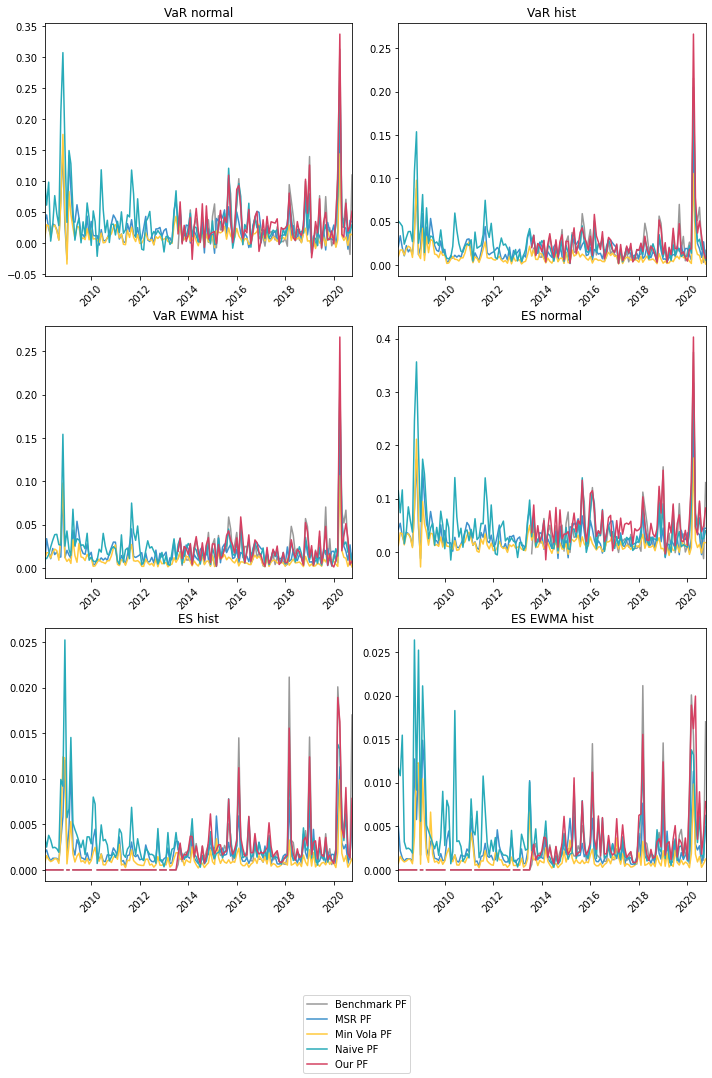

------------------------------
Data Tables:
------------------------------

VaR normal:
* Table output was shrtened to 50 rows.

              Benchmark PF    MSR PF    Min Vola PF    Naive PF    Our PF
----------  --------------  --------  -------------  ----------  --------
2008-01-31             nan    0.0346         0.0080      0.1010       nan
2008-02-29             nan    0.0456         0.0297      0.0614       nan
2008-03-31             nan    0.0229         0.0277      0.0985       nan
2008-04-30             nan    0.0135         0.0090      0.0033       nan
2008-05-31             nan    0.0309         0.0277      0.0294       nan
2008-06-30             nan    0.0294         0.0291      0.0767       nan
2008-07-31             nan    0.0217         0.0200      0.0473       nan
2008-08-31             nan    0.0055         0.0048      0.0283       nan
2008-09-30             nan    0.0715         0.0651      0.2114       nan
2008-10-31             nan    0.1501         0.1754      

In [11]:
combined = {}
for day, DF in df_date_period_iterator(store_exercise_1, period='m', true_date=True):
    tmp_VaR = VaR(DF, p=0.95, method=['normal','hist'], output='VaR', n_days=20, ewma=False).rename(columns={'hist':'VaR hist', 'normal':'VaR normal'})
    tmp_EWMA_VaR = VaR(DF, p=0.95, method=['hist'], output='VaR', n_days=20, ewma=0.5).rename(columns={'hist':'VaR EWMA hist'})
    tmp_VaR = pd.concat([tmp_VaR, tmp_EWMA_VaR], axis=1)
    tmp_ES = VaR(DF, p=0.95, method=['normal','hist'], output='ES', n_days=20, ewma=False).rename(columns={'hist':'ES hist', 'normal':'ES normal'})
    tmp_EWMA_ES = VaR(DF, p=0.95, method=['hist'], output='ES', n_days=20, ewma=0.5).rename(columns={'hist':'ES EWMA hist'})
    tmp_ES = pd.concat([tmp_ES, tmp_EWMA_ES], axis=1)
    combined[day] = pd.concat([tmp_VaR, tmp_ES], axis=1)

combined = transpose_dict_DF(combined, [('head','index'),('dict_key','index')])
store4a = combined.copy()

custom_plot(combined)

exp_dict = {}
exp_dict.update(combined)
exp_dict['DATA'] = store_exercise_1
excel_exporter(exp_dict, 'results/assignment_2-exercise_4a.xlsx')
excel_exporter(exp_dict, 'results/assignment_2-exercise_4c.xlsx')

<b>Answer:</b> Above we firstly calculated the 20-day 95% VaR and Expected Shortfall for five portfolios including the min-volatitily portfolio, naive portfolio and the original weighted portfolio from Assignment 1 as well as the baseline portfolio and benchmark portfolio using both delta-normal approach and historical simulation. 

When choosing the past window of price data to estimate the Value-at-Risk, we used all the previous price data we have since this way we could have the most sufficient information. For benchmark portfolio and baseline portfolio we started from July 1st 2013, and for the other three portfolio we started from January 3rd 2018.

During the time period January 1st 2016 to September 1st 2020, we can see that the Value-at-Risk calculated from Delta-Normal approach is higher than the historical simulation, so does the expected shortfall. The Value-at-Risk calculated from an exponentially weighted moving average of the weights of the historical daily observations is generally higher compared to an equally-weighted 252 days historical rolling window, although there are violations during some periods. The reason for this result is that recent observations are given more weight and the largest loss have occured relatively recently. One disadvantage of the EWMA approach relative to the equally-weighted 252 days historical rolling window is that the effective sample size is reduced. However, here we used a relatively large dataset and total observations of loss data, so this disadvantage is compensated.

#### 4b)
For each of the predicted VAR and ES numbers, report number of violations in the years 2016 to 2020, and explain how restrictive your VAR and ES numbers are. 

Would you suggest any adjustments to the methodology? In particular how did the VaR and ES evolve during the recent Corona crisis and how many violations could be observed?

**Note:** Here we report the number of violations compared to the estimated VaR that is calculated from the basic historical simulation from exercise 4a.

In [12]:
breach_list, breach_overview = check_VaR_violations(store_exercise_1, store4a['VaR hist'])
ES_avg = pd.DataFrame(store4a['ES hist'].mean().rename('Average est ES'))

print_nice_data_tables(breach_overview, max_rows=50)
print_nice_data_tables(ES_avg, heading=False)

print('\n\nList of all breaches:')
print_nice_data_tables(breach_list, max_rows=False)

exp_dict = {}
exp_dict['Breach list'] = breach_list
exp_dict['Breach Overview'] = breach_overview
exp_dict['Average ES'] = ES_avg
excel_exporter(exp_dict, 'results/assignment_2-exercise_4b.xlsx')

------------------------------
Data Table:
------------------------------
PF              # VaR Exceeded    Actual avg. loss    Average est. VaR    Percentage    Observations
------------  ----------------  ------------------  ------------------  ------------  --------------
Our PF                     116              0.0302              0.0143        0.0646            1796
Benchmark PF                59              0.0100              0.0056        0.0329            1796
MSR PF                      26              0.0093              0.0046        0.0145            1796
Min Vola PF                 44              0.0050              0.0022        0.0245            1796
Naive PF                    41              0.0087              0.0047        0.0228            1796

                Average est ES
------------  ----------------
Benchmark PF            0.0019
MSR PF                  0.0021
Min Vola PF             0.0013
Naive PF                0.0031
Our PF                  0.0019



We can see from the table above that between 2016 to 2020 we have in toal 1796 observations, among which our portfolio (baseline portfolio) shows 116 violations of which the loss exceeded the estimated VaR, and that yields 6.46% as the cutoff point for VaR, which is higher than the 5% as from the 95% confidence level. The actuall average loss,i.e. the expected shortfall is 0.0308, while the predicted expected shortall is only 0.0032. For the Benchmark portfolio we report 59 violations whose loss exceeded our estimated VaR. The acutal expected shortfall of the benchmark portfolio is 0.01, which is much higer than the estimated ES of 0.0019.

Apart from the benchmark portfolio and the baseline portfolio, we also verified the prediction accuracy for the other three portfolios from Assignment 1. Among them the min-volatility portfolio shows the highest number of violations. 538 of 1796 observations exceeded the estimated VaR which reduced the confidence level to around 70%. 

During the recent Corona crisis in 2020, the baseline portfolio shows 10 violations and the benchmark portfolio shows 12 violations;specifically the min-volatitly portfolio shows 57 violations. Compared to the number of violations in the previous year, in which the baseline portfolio, benchmark portfolio and the min-volatility portfolio report 16,15 and 249 violations respectively, the Corona crisis does not increase the number of violations significantly.

Our methodology used all the previous data as the past window to estimate the VaR using the basic historical simulation. Potential bias could come from the long time period from which some old data might not be predictable and related to our current economic situation anymore.

#### 4c)
Compare the 20-day 95% VaR and ES from January 1st 2016 until September 1st 2020 for the portfolios from task 1:
- our PF
- MSR,
- MinV, and
- simple 1/N portfolio.

Which portfolio, besides the “naïve” baseline portfolio and the benchmark portfolio, provided the lowest VaR and ES at the end of January 31st 2020 before the Corona crisis hit the financial markets? Do the VaR and ES ex-ante predict reasonably how sensitive the portfolios are to exogeneous shocks like the Corona crisis with large drawdowns from February 20th to March 23rd 2020?

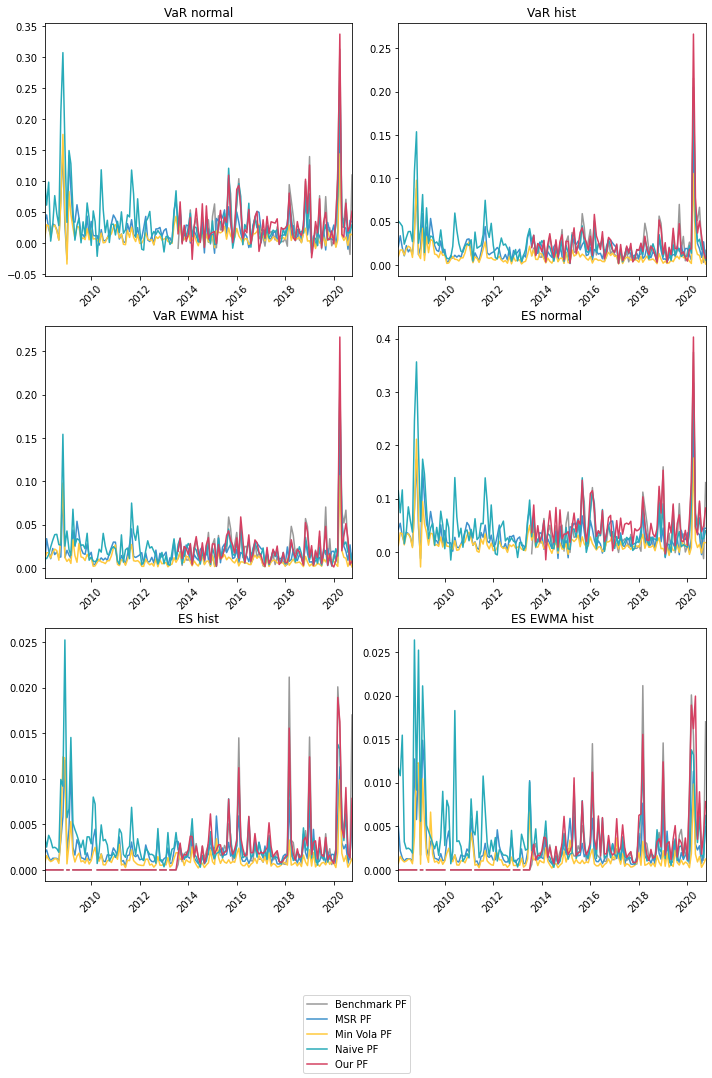

------------------------------
Data Tables:
------------------------------

VaR normal:
* Table output was shrtened to 50 rows.

              Benchmark PF    MSR PF    Min Vola PF    Naive PF    Our PF
----------  --------------  --------  -------------  ----------  --------
2008-01-31             nan    0.0346         0.0080      0.1010       nan
2008-02-29             nan    0.0456         0.0297      0.0614       nan
2008-03-31             nan    0.0229         0.0277      0.0985       nan
2008-04-30             nan    0.0135         0.0090      0.0033       nan
2008-05-31             nan    0.0309         0.0277      0.0294       nan
2008-06-30             nan    0.0294         0.0291      0.0767       nan
2008-07-31             nan    0.0217         0.0200      0.0473       nan
2008-08-31             nan    0.0055         0.0048      0.0283       nan
2008-09-30             nan    0.0715         0.0651      0.2114       nan
2008-10-31             nan    0.1501         0.1754      

In [13]:
custom_plot(store4a)

</b>Answer:</b>

Interpreting historical VaR

It is not straightforward to identify the portfolio which performs the best in terms of VaR, as the values of each portfolio fluctuate each period. The VaR of the baseline portfolio (our portfolio) seems to mirror the VaR of the naive portfolio, both being on average above the VaR of the MSR portfolio.

Overall, the observed VaR and ES developments are characterized by being steady until the Corona crisis hits. A big jump in VaR can be observed for the portfolios at end of February 2020, which is mainly contributed to the impact of the corona virus on the global economy. 

The ES of the portfolios are also steady over the whole period, however there are two peaks in the ES in year 2018, one at the beginning and one around the months of October. The ES also significantly increases in the months of February and March 2020.

Besides the “naïve” baseline portfolio and the benchmark portfolio, the miminmum variance portfolio provides the lowest VaR and ES at the end of January 31st 2020 before the Corona crisis hit the financial markets.

VaR and ES ex-ante and backward looking measures. The level of potential future risk exposure is derived from taking past data points as potential outcomes (historical simulation) or by using the distribution properties from past data (delta normal). Both approaches are not reasonably predicting sensitivities of the portfolios to exogeneous shocks like the Corona crisis. The time period (past data) used for the VaR calculation at the end of January 2020 does not contain losses in the scale of  a tail event such as the Corona crisis. Therefore it cannot capture the sensitivity of the portfolios to the exogenous shock. However, the increased volatility of returns in February is capture at the end of February 2020. 




#### 4d)
Use our portfolio from task 1a) and replace the Russel 2000 ETF, which accounts for 70% in the 60% equity allocation, with the iShares Edge MSCI Min Vol USA ETF (USMV). 

Calculate as of January 31st 2020:
- returns, 
- volatility, 
- sharpe ratio, and 
- maximum drawdown 

by using 
- (1): the delta-normal or parametric approach assuming a normal distribution of the portfolio returns,
    - VaR
    - ES
- (2): historical simulation
    - VaR
    - ES

Are the 20-day 95% VaR and ES good predictors which portfolio would make less losses, in absolute terms, in the case of an exogeneous shock like the corona crisis?

Finally, construct the Markowitz minimum volatility (MinV) portfolio as of January 31st 2020 and calculate the same figures as above.

Elaborate what you observe and whether you would recommend as financial advisor such an optimized or simple “minimum volatility” portfolio to a risk-averse client.

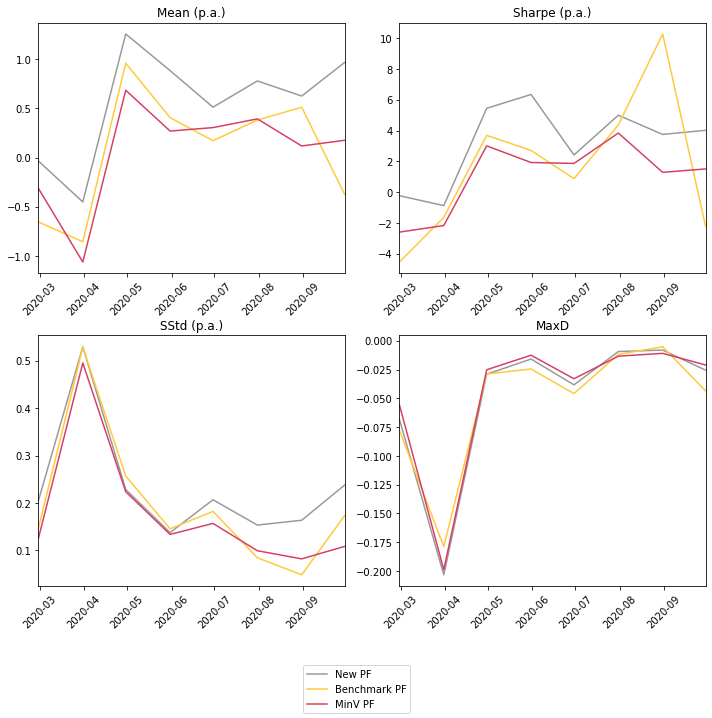

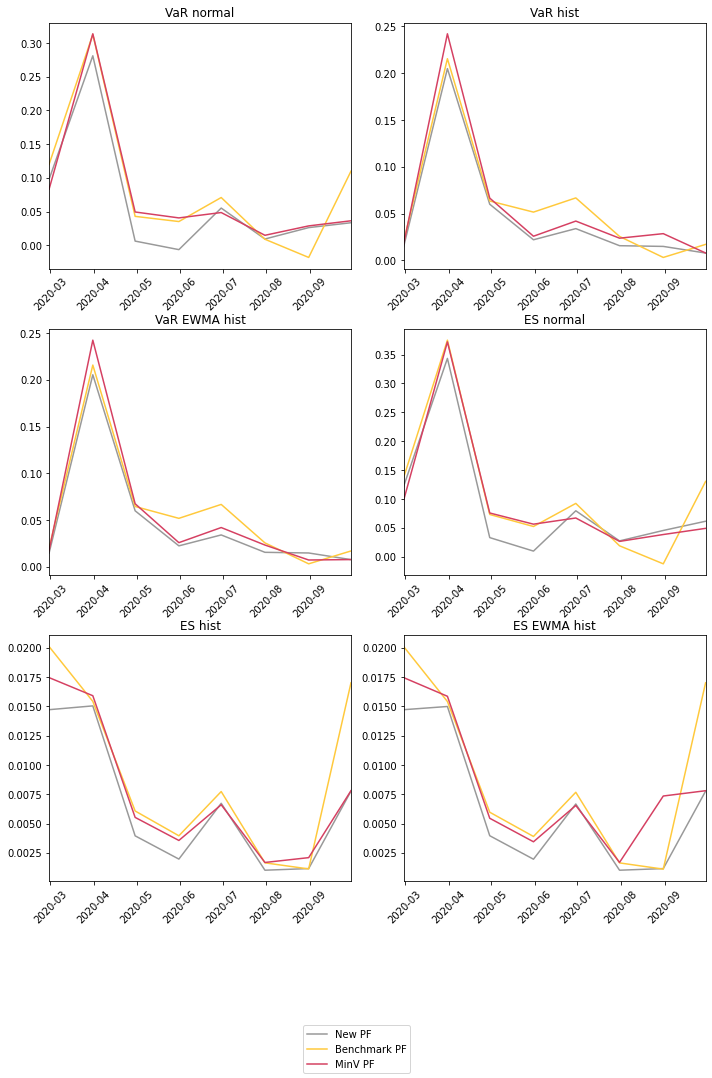

------------------------------
Data Tables:
------------------------------

Mean (p.a.):
              New PF    Benchmark PF    MinV PF
----------  --------  --------------  ---------
2020-02-29   -0.0351         -0.6542    -0.3141
2020-03-31   -0.4507         -0.8556    -1.0617
2020-04-30    1.2562          0.9594     0.6845
2020-05-31    0.8845          0.4061     0.2697
2020-06-30    0.5123          0.1718     0.3048
2020-07-31    0.7791          0.3814     0.3935
2020-08-31    0.6257          0.5114     0.1180
2020-09-30    0.9670         -0.3732     0.1758


Sharpe (p.a.):
              New PF    Benchmark PF    MinV PF
----------  --------  --------------  ---------
2020-02-29   -0.2305         -4.5398    -2.5965
2020-03-31   -0.8746         -1.6425    -2.1692
2020-04-30    5.4448          3.6878     3.0048
2020-05-31    6.3439          2.7078     1.9250
2020-06-30    2.4182          0.8756     1.8641
2020-07-31    4.9964          4.3654     3.8389
2020-08-31    3.7493         1

In [14]:
new_weight_dict = {'iShares Edge MSCI Min Vol USA ETF (USMV) $': 0.42, 'iShares STOXX Europe 600 UCITS ETF (DE) (EXSA.DE) $': 0.1, 'iShares MSCI Emerging Markets ETF (EEM) $': 0.06, 'iShares Core Nikkei 225 ETF (1329.T) $': 0.06, 'iShares 20+ Year Treasury Bond ETF (TLT) $': 0.1, 'iShares Core U.S. Aggregate Bond ETF (AGG) $': 0.1, 'SPDR Bloomberg Barclays High Yield Bond ETF (JNK) $': 0.1, 'iShares iBoxx $ Investment Grade Corporate Bond ETF (LQD) $':0.1}
available_assets = new_weight_dict.keys()

# Remove data before 2013-07-01
df_returns = df1.pct_change().loc['2020-02-01':]
df_returns_mvola = df1[available_assets].loc['2011-10-21':'2020-02-01']

# Dictionary with weights from task
mvola_weight_dict = PF_weights(df_returns_mvola, output='MVol')

# Check for NaN
#print('NaN:', df_returns[df_returns.isna().any(axis=1)])

combined_VaR = {}
PF_moments = {}

# Get PF returns for each quater
for q, data in df_date_period_iterator(df_returns, period='m', true_date=True):
    new_PF = PF_value_with_rebalancing(data, new_weight_dict, initial_investment=1, rebalancing='m',
                                       percentage=True)['PF Total'].rename('New PF')
    benchmark_PF = PF_value_with_rebalancing(data, benchmark_weight_dict, initial_investment=1, rebalancing='m',
                                             percentage=True)['PF Total'].rename('Benchmark PF')
    mvola_PF = PF_value_with_rebalancing(data, mvola_weight_dict, initial_investment=1, rebalancing='m', percentage=True)['PF Total'].rename('MinV PF')
    
    # Calculate quaterly moments
    all_together = pd.concat([new_PF, benchmark_PF, mvola_PF], axis=1, sort=False)
    PF_moments[q] = moments(all_together, output=['Mean (p.a.)', 'Sharpe (p.a.)', 'SStd (p.a.)', 'MaxD'], r_f=r_f)

    # VaR and ES
    tmp_VaR = VaR(all_together, p=0.95, method=['normal','hist'], output='VaR', n_days=20, ewma=False).rename(columns={'hist':'VaR hist', 'normal':'VaR normal'})
    tmp_EWMA_VaR = VaR(all_together, p=0.95, method=['hist'], output='VaR', n_days=20, ewma=0.5).rename(columns={'hist':'VaR EWMA hist'})
    tmp_VaR = pd.concat([tmp_VaR, tmp_EWMA_VaR], axis=1)
    tmp_ES = VaR(all_together, p=0.95, method=['normal','hist'], output='ES', n_days=20, ewma=False).rename(columns={'hist':'ES hist', 'normal':'ES normal'})
    tmp_EWMA_ES = VaR(all_together, p=0.95, method=['hist'], output='ES', n_days=20, ewma=0.5).rename(columns={'hist':'ES EWMA hist'})
    tmp_ES = pd.concat([tmp_ES, tmp_EWMA_ES], axis=1)
    combined_VaR[q] = pd.concat([tmp_VaR, tmp_ES], axis=1)



# Remove unneccesary Moments that are not asked for in task
PF_moments = transpose_dict_DF(PF_moments, [('head', 'index'),('dict_key','index')])
combined_VaR = transpose_dict_DF(combined_VaR, [('head','index'),('dict_key','index')])


# Show results
custom_plot(PF_moments, print_data=False)
custom_plot(combined_VaR, print_data=False)
print_nice_data_tables(PF_moments)
print_nice_data_tables(combined_VaR, heading=False)

exp_dict = {}
exp_dict.update(PF_moments)
exp_dict.update(combined_VaR)
exp_dict['Breach list'] = breach_list
exp_dict['Breach Overview'] = breach_overview
exp_dict['Average ES'] = ES_avg
excel_exporter(exp_dict, 'results/assignment_2-exercise_4d.xlsx')


<b>Answer:</b> The 20-day 95% VaR and ES are not a good predictor for which portfolio would make less losses, in absolute terms, in case of an exogenous shock, like the corona crisis. This is because the two figures relate to a past period. In the case of the corona crisis, for example, the 20-day 95% VaR and ES before the crisis would have tended to predict lower losses than those that ultimately occurred. Similarly, the heavy losses during the corona crisis meant that the 20-day retrospective predicted much larger losses than those that subsequently occurred. Furthermore, the differences in VaR and ES with regard to the respective portfolios are not very pronounced, especially during exogenous shocks like the corona crisis, which makes it difficult to make decisions based on their absolute values.

 

However, if we compare the minimum volatility portfolio with the benchmark portfolio and the MSR portfolio, it is clear that the VaR and ES show a very similar pattern throughout the entire period. In terms of pure risk minimization, measured by VaR and ES, a risk-averse investor might not necessarily be well advised to use the minimum volatility portfolio. Especially, if we recall the previous tasks, we have seen that this is also associated with lower returns.  It is also evident that the differences in VaR and ES between the individual portfolios, especially during the corona crisis, are only marginal. It is even noticeable that during the crisis, VaR and ES of the minimum volatility portfolio are greater than those of the new portfolio.

 

In the event of exogenous shocks, such as the corona crisis, even a risk-averse investor would therefore be better advised to look for such an optimized portfolio.